<a href="https://colab.research.google.com/github/alisonsoong/NASA-SEES-2021-Emergency-Preparedness/blob/main/Floods_And_Tropical_Storms_Group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flood/Tropical Storms Group: 
##Time Series Charts/Animation of Soil Moisture/Precipitation in Florida-Carribean Region
## Adelene Chan, Neha Vardhaman, Sabrina Chang, Sophia Lin



# Time Series Charts
Time series region reduction in Earth Engine, converting EE table to pandas DataFrame, representing data with matplotlib.pyplot. 

Feel free to make a copy and use your own datasets.

##References:
- [GEE Developers Time Series Visualization w/ Altair](https://developers.google.com/earth-engine/tutorials/community/time-series-visualization-with-altair#drought_severity) - for region reduction, EE table to DataFrame, DataFrame alterations
- [WorldBank Mod4.1 Time Series Charts](https://worldbank.github.io/OpenNightLights/tutorials/mod4_1_time_series_charts.html) - for matplotlib plotting, additional DataFrame functions

##Process:
1. Import ee, geemap, json, pandas, seaborn, matplotlib.pyplot, numpy. 
2. Filter dataset (server-side EE)
3. Reduce data region (server-side EE)
4. Convert EE table to Dataframe (server-side EE -> client-side Python kernel)
5. Alter DataFrame (client-side pandas)
6. Plot DataFrame (client-side matplotlib) 

##Datasets and Area of Interest:
- Area of interest: Florida Carribean Region (ee.Geometry.Polygon)
- 'ssm' (surface soil moisture in mm) band from [NASA-USDA Enhanced SMAP Global Soil Moisture Data](https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_SMAP10KM_soil_moisture#description)
- 'precipitationCal' (calibrated precipitation in mm/hr) band from [GPM: Global Precipitation Measurement (GPM) v6](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_V06)
- 'precipitation' (satellite-gauge precipitation estimate in mm/hr)[GPM: Monthly Global Precipitation Measurement (GPM) v6](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_MONTHLY_V06)


#Imports

In [ ]:
import ee

## Trigger the authentication flow. You only need to do this once
ee.Authenticate()

# Initialize the library.
ee.Initialize()

# Installs geemap package
import subprocess

try:
    import geemap
    print("geemap is imported and ready to use in Colab")
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])
    import geemap
    print("geemap is now installed, imported and ready to use in Colab") 

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=_dezRVFpTPg5BLuh1ooSZJc9KMxwbPMz4xO-VEqnZ4U&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiZQDPawyfHky0pkwyESA8z7Hh5JjPntSuvnCyWq2MNX_KSj1Fw2cc

Successfully saved authorization token.
geemap is imported and ready to use in Colab


In [ ]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Time Series Functions for Data
[GEE Developers Time Series Visualization w/ Altair](https://developers.google.com/earth-engine/tutorials/community/time-series-visualization-with-altair#drought_severity)

##Region Reduction Function

In [ ]:
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

In [ ]:
def create_reduce_region_function(geometry, reducer=ee.Reducer.mean(), 
                                  scale=1000, crs='EPSG:4326',
                                  bestEffort=True, maxPixels=1e13, tileScale=4):
  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

###Info on function arguments



```
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function
```


##Formatting
Return dictionary from ee.FeatureCollection


In [ ]:
# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

#Surface Soil Moisture (ssm) ImageCollection and Area of Interest

[NASA-USDA Enhanced SMAP Global Soil Moisture Data](https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_SMAP10KM_soil_moisture#description)


In [ ]:
ssm = ee.ImageCollection("NASA_USDA/HSL/SMAP10KM_soil_moisture").filterDate('2017-01-01','2018-01-01').select('ssm')
aoi = ee.Geometry.Polygon([[-88.20, 30.99], [-59.68, 20.06] , [-62.45, 8.09] , [-86.48, 14.29]]) #4 sided polygon with Florida, Puerto Rico, Carribean area within

##For geometries, can possibly use poi and buffer (if big enough compared to scale) and other aoi's with FeatureCollections 
# poi = ee.Geometry.Point(-66.11, 18.47).buffer(500) 
# aoi = ee.FeatureCollection('EPA/Ecoregions/2013/L3').filter(
#     ee.Filter.eq('na_l3name', 'Sierra Nevada')).geometry()

##Map AOI 
This is optional, but it's nice to see what we are working on.

In [ ]:
# Map instance
Map = geemap.Map() 

# Area of Interest (same 'aoi' as above)
aoi_map = ee.Geometry.Polygon([[-88.20, 30.99], [-59.68, 20.06] , [-62.45, 8.09] , [-86.48, 14.29]])

# Image Collection (same as 'ssm' above)
ssm_map = ee.ImageCollection("NASA_USDA/HSL/SMAP10KM_soil_moisture").filterDate('2017-01-01','2018-01-01').select('ssm').filterBounds(aoi_map).median()

# Image display parameters
ssm_param = {
    'min': 0.0,
    'max': 25.0,
    'palette': ['0300ff', '418504', 'efff07', 'ff0303'], 
    #'palette': ['f1eef6', 'bdc9e1', '74a9cf', '2b8cbe', '045a8d'],
    'bands': 'ssm', # pick 1
    'geometry':'aoi_map'
}

# Clipping map to just display area of interest
ssm_aoi= ssm_map.clip(aoi_map)

# Center map
Map.center_object(aoi_map, zoom = 5)

# Add map layer
Map.addLayer(ssm_aoi, ssm_param, "ssm Map of Florida-Carribean Region")

# Add legend
names = ['0.0-5.0','5.0-10.0','15.0-20.0','20.0-25.0']
palette = ['0300ff', '418504', 'efff07', 'ff0303']
legend_dict = dict(zip(names,palette))
Map.add_legend(title='SSM (mm)',legend_dict=legend_dict, position='bottomleft')

# Display
Map

##Reduce Data

1. Create a region reduction function.
2. Map the function over the desired image collection (ssm) to reduce each image.
3. Filter out any resulting features that have null computed values (occurs when all pixels in an AOI are masked).

In [ ]:
reduce_ssm = create_reduce_region_function(
    geometry=aoi, reducer=ee.Reducer.mean(), scale=10000) #, crs='EPSG:3310'

ssm_stat_fc = ee.FeatureCollection(ssm.map(reduce_ssm)).filter(
    ee.Filter.notNull(ssm.first().bandNames()))

##Servent to client transfer
The ee.FeatureCollection needs to be converted to a dictionary and transferred to the Python kernel.

1. Apply the fc_to_dict function to convert from ee.FeatureCollection to ee.Dictionary.
2. Call getInfo() on the ee.Dictionary to transfer the data client-side.



In [ ]:
ssm_dict = fc_to_dict(ssm_stat_fc).getInfo()


In [ ]:
#just to see how it's formatted
print(type(ssm_dict), '\n')
for prop in ssm_dict.keys():
    print(prop + ':', ssm_dict[prop][0:3] + ['...'])



<class 'dict'> 

millis: [1483444800000, 1483704000000, 1483963200000, '...']
ssm: [15.959310846353194, 16.775050132680757, 16.424203309209126, '...']
system:index: ['NASA_USDA_SMAP_SM20170103_20170105', 'NASA_USDA_SMAP_SM20170106_20170108', 'NASA_USDA_SMAP_SM20170109_20170111', '...']


##Python dict to pandas DataFrame

In [ ]:
# Convert the Python dictionary to a pandas DataFrame.

ssm_df = pd.DataFrame(ssm_dict) #df stands for DataFrame


In [ ]:
# Preview the DataFrame and check the column data types.

display(ssm_df)
print(ssm_df.dtypes)

,millis,ssm,system:index
0,1483444800000,15.959311,NASA_USDA_SMAP_SM20170103_20170105
1,1483704000000,16.775050,NASA_USDA_SMAP_SM20170106_20170108
2,1483963200000,16.424203,NASA_USDA_SMAP_SM20170109_20170111
3,1484222400000,15.747155,NASA_USDA_SMAP_SM20170112_20170114
4,1484481600000,15.236185,NASA_USDA_SMAP_SM20170115_20170117
...,...,...,...
116,1513512000000,18.795176,NASA_USDA_SMAP_SM20171217_20171219
117,1513771200000,18.500953,NASA_USDA_SMAP_SM20171220_20171222
118,1514030400000,18.064526,NASA_USDA_SMAP_SM20171223_20171225
119,1514289600000,18.213604,NASA_USDA_SMAP_SM20171226_20171228


millis            int64
ssm             float64
system:index     object
dtype: object


#Reformatting DataFrame - add/rename/drop columns

##Add date columns

In [ ]:
# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms') #important - changes from ms to timestamp
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [ ]:
# Preview the results
ssm_df = add_date_info(ssm_df)
ssm_df.head(5)

,millis,ssm,system:index,Timestamp,Year,Month,Day,DOY
0,1483444800000,15.959311,NASA_USDA_SMAP_SM20170103_20170105,2017-01-03 12:00:00,2017,1,3,3
1,1483704000000,16.775050,NASA_USDA_SMAP_SM20170106_20170108,2017-01-06 12:00:00,2017,1,6,6
2,1483963200000,16.424203,NASA_USDA_SMAP_SM20170109_20170111,2017-01-09 12:00:00,2017,1,9,9
3,1484222400000,15.747155,NASA_USDA_SMAP_SM20170112_20170114,2017-01-12 12:00:00,2017,1,12,12
4,1484481600000,15.236185,NASA_USDA_SMAP_SM20170115_20170117,2017-01-15 12:00:00,2017,1,15,15


## Rename and drop columns

In [ ]:
# Change ssm to SSM, remove other columns
ssm_df = ssm_df.rename(columns={
    'ssm': 'SSM',
}).drop(columns=['millis', 'system:index','Year','Month','Day','DOY'])
ssm_df.head(5) #preview

,SSM,Timestamp
0,15.959311,2017-01-03 12:00:00
1,16.775050,2017-01-06 12:00:00
2,16.424203,2017-01-09 12:00:00
3,15.747155,2017-01-12 12:00:00
4,15.236185,2017-01-15 12:00:00


In [ ]:
# Change timestamp to date
ssm_df = ssm_df.rename(columns={
    'Timestamp': 'date'
})
ssm_df.head(5) #preview

,SSM,date
0,15.959311,2017-01-03 12:00:00
1,16.775050,2017-01-06 12:00:00
2,16.424203,2017-01-09 12:00:00
3,15.747155,2017-01-12 12:00:00
4,15.236185,2017-01-15 12:00:00


In [ ]:
# Change index from 0, 1, 2 ... to dates 2017-01-03 ...
ssm_df = ssm_df.set_index('date')
ssm_df


,SSM
date,
2017-01-03 12:00:00,15.959311
2017-01-06 12:00:00,16.775050
2017-01-09 12:00:00,16.424203
2017-01-12 12:00:00,15.747155
2017-01-15 12:00:00,15.236185
...,...
2017-12-17 12:00:00,18.795176
2017-12-20 12:00:00,18.500953
2017-12-23 12:00:00,18.064526


In [ ]:
# Check datatype of each column
ssm_df.dtypes


SSM    float64
dtype: object

#Graphing w/ matplotlib.pyplot

The 'altair' library is another option: more examples in [GEE Developers Time Series Visualization w/ Altair](https://developers.google.com/earth-engine/tutorials/community/time-series-visualization-with-altair#drought_severity): calendar heatmap, bar chart with drought severity and other datasets like modis ndvi and

Referencing [WorldBank Mod4.1 Time Series Charts](https://worldbank.github.io/OpenNightLights/tutorials/mod4_1_time_series_charts.html) 

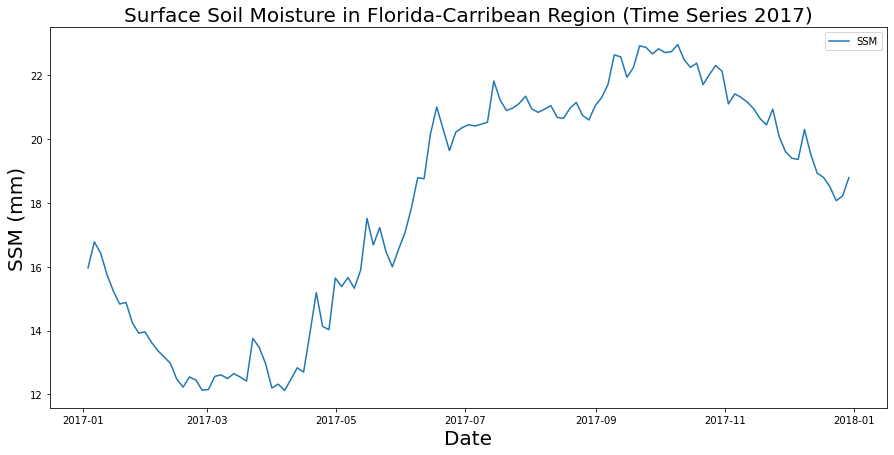

In [ ]:
# Create a figure with pyplot and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15,7))

# Create the plot by setting our dataframe to the data argument
sns.lineplot(data=ssm_df, ax=ax)

# Set the labels and title
ax.set_ylabel('SSM (mm)',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Surface Soil Moisture in Florida-Carribean Region (Time Series 2017)',fontsize=20);

In [ ]:
# Addtional dataframe observations: peak
ssm_df.idxmax() # in this case, we see highest surface soil moisture (ssm) on 10/9/2017 

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html (Other DataFrame functions here)

SSM   2017-10-09 12:00:00
dtype: datetime64[ns]

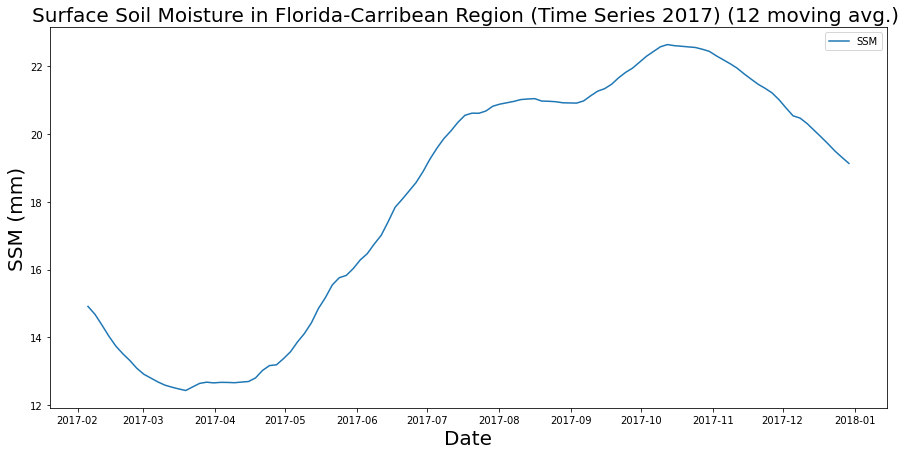

In [ ]:
# If you want to smooth out time series :
fig, ax = plt.subplots(figsize=(15,7))

# Plot the moving averate using ".rolling" and set a window of 12 months
window=12 # the higher the window, the smoother
sns.lineplot(data=ssm_df.rolling(window).mean(), ax=ax)

# Set the labels and title
ax.set_ylabel('SSM (mm)',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title(f'Surface Soil Moisture in Florida-Carribean Region (Time Series 2017) ({window} moving avg.) ',fontsize=20);

Congratulations! The dataset has been rearranged into a pandas DataFrame and graphed using matplotlib. 

#Additional Datasets: Global Precipitation Measurement

The above code can be modified to fit other datasets. 

However, datasets vary greatly such as the frequency of the data over time. We can adjust timeframes or even resample the data to fit our desired time intervals.


#Resampling Example (30 min -> 3 day increment) - GPM: Global Precipitation Measurement (GPM) v6
The 'ssm' imageCollection had a frequency of every 3 days making a nice annual time series. If we want to compare surface soil moisture with precipitation, we will need to modify the 'GPM: Global Precipitation Measurement (GPM) v6' data from every 30 min to every 3 days. 
- Changing frequency of data in DataFrame.
- The available precipitation datasets are: 
  - [GPM: Global Precipitation Measurement (GPM) v6](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_V06) - too frequent (every 30 min)
  - [GPM: Monthly Global Precipitation Measurement (GPM) v6](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_MONTHLY_V06) - not frequent enough (every month)

- We will use a resampling function, after arranging the pandas DataFrame, to convert the 'GPM: Global Precipitation Measurement (GPM) v6' data from 30 min to 3 day increments.

In [ ]:
#Image Collection and AOI

precip3D = ee.ImageCollection("NASA/GPM_L3/IMERG_V06").filterDate('2017-01-01','2017-12-31').select('precipitationCal')
aoi = ee.Geometry.Polygon([[-88.20, 30.99], [-59.68, 20.06] , [-62.45, 8.09] , [-86.48, 14.29]]) #4 sided polygon with Florida, Puerto Rico, Carribean area within

In [ ]:
# Apply region reduction function (if you haven't already, make sure to run cell defining function above)
reduce_precip3D = create_reduce_region_function(
    geometry=aoi, reducer=ee.Reducer.mean(), scale=11100) #, crs='EPSG:3310'

precip3D_stat_fc = ee.FeatureCollection(precip3D.map(reduce_precip3D)).filter(
    ee.Filter.notNull(precip3D.first().bandNames()))

In [ ]:
# Apply fc_to_dict function (if you haven't already, make sure to run cell defining function above) 
# Note: Large dataset - feel free to shorten date range
precip3D_dict = fc_to_dict(precip3D_stat_fc).getInfo() 

In [ ]:
# Check the format of the dictionary
print(type(precip3D_dict), '\n')
for prop in precip3D_dict.keys():
    print(prop + ':', precip3D_dict[prop][0:3] + ['...'])

In [ ]:
# Python dict to pandas

# Convert the Python dictionary to a pandas DataFrame.
precip3D_df = pd.DataFrame(precip3D_dict) #df stands for DataFrame

# Preview
display(precip3D_df)
print(precip3D_df.dtypes)

In [ ]:
# Function to add date variables to DataFrame 
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms') #important - changes from ms to timestamp
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [ ]:
# Apply add_date_info function 
precip3D_df = add_date_info(precip3D_df)

# Preview
precip3D_df.head(5)

In [ ]:
# Change precipitationCal to Precipitation, remove other columns
precip3D_df = precip3D_df.rename(columns={
    'precipitationCal': 'Precipitation',
}).drop(columns=['millis', 'system:index','Year','Month','Day','DOY'])

# Change timestamp to date
precip3D_df = precip3D_df.rename(columns={
    'Timestamp': 'Date'
})

# Preview
precip3D_df.head(5) 


In [ ]:
# Change index from 0, 1, 2 ... to dates 2017-01-03 ...
precip3D_df = precip3D_df.set_index('Date')

#Preview
precip3D_df

In [ ]:
# Check datatype of each column
precip3D_df.dtypes

##"Resampling" dataframe 
Pandas documentation for [resampling or converting a time series to a particular frequency](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)


The original dataframe has many thousands of rows since our time of interest is 1 year and measurements were taken every 30 min.

Pandas resample function:


```
new_df = df.resample("3D").mean()
```
3D = 3 days
- For example, if you want to resample to every 2 hours, replace "3D" with "2H".


In [ ]:
# Apply pandas resample function
precip3D_df = precip3D_df.resample("3D").mean() 

# "3D" is the "frequency" argument - so you can go "H" for hour, etc
precip3D_df

The data has now been resampled. We went from 17472 rows to 122 rows.

In [ ]:
# Graphing precip3D

# Create a figure with pyplot and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15,7))

# Create the plot by setting our dataframe to the data argument
sns.lineplot(data=precip3D_df, ax=ax)

# Set the labels and title
ax.set_ylabel('Precipitation (mm/hr)',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Calibrated Precipitation in Florida-Carribean Region (Time Series 2017 (each 3days))',fontsize=20);

In [ ]:
# If you want to smooth out time series :
fig, ax = plt.subplots(figsize=(15,7))

# Plot the moving averate using ".rolling" and set a window of 12 months
window=12 # the higher the window, the smoother
sns.lineplot(data=precip3D_df.rolling(window).mean(), ax=ax)

# Set the labels and title
ax.set_ylabel('Precipitation (mm/hr)',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title(f'Calibrated Precipitation in Florida-Carribean Region (Time Series 2017 (each 3days) ({window} moving avg.) ',fontsize=20);

In [ ]:
precip3D_df.idxmax() #peak rainfall on 2017-09-07 

#Smaller Timeframes Example - GPM: Global Precipitation Measurement (GPM) v6

We can still use the original data (measurements every 30 min) for much smaller timeframes, such as a few days. 

[GPM: Global Precipitation Measurement (GPM) v6](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_V06)

In [ ]:
#Image Collection and AOI
precip = ee.ImageCollection("NASA/GPM_L3/IMERG_V06").filterDate('2017-08-27','2017-08-31').select('precipitationCal') #August 27-31, 2017
aoi = ee.Geometry.Polygon([[-88.20, 30.99], [-59.68, 20.06] , [-62.45, 8.09] , [-86.48, 14.29]]) #4 sided polygon with Florida, Puerto Rico, Carribean area within

In [ ]:
# Apply region reduction function (if you haven't already, make sure to run cell defining function above)
reduce_precip = create_reduce_region_function(
    geometry=aoi, reducer=ee.Reducer.mean(), scale=11100) #, crs='EPSG:3310'

precip_stat_fc = ee.FeatureCollection(precip.map(reduce_precip)).filter(
    ee.Filter.notNull(precip.first().bandNames()))

In [ ]:
# Apply fc_to_dict function (if you haven't already, make sure to run cell defining function above)(if you haven't already, make sure to run cell defining function above)
precip_dict = fc_to_dict(precip_stat_fc).getInfo()

In [ ]:
# Check the format of the dictionary
print(type(precip_dict), '\n')
for prop in precip_dict.keys():
    print(prop + ':', precip_dict[prop][0:3] + ['...'])

<class 'dict'> 

millis: [1503792000000, 1503793800000, 1503795600000, '...']
precipitationCal: [0.2170490901720058, 0.20592850181322375, 0.19105046148561053, '...']
system:index: ['20170827000000', '20170827003000', '20170827010000', '...']


In [ ]:
# Python dict to pandas

# Convert the Python dictionary to a pandas DataFrame.
precip_df = pd.DataFrame(precip_dict) #df stands for DataFrame

# Preview
display(precip_df)
print(precip_df.dtypes)

,millis,precipitationCal,system:index
0,1503792000000,0.217049,20170827000000
1,1503793800000,0.205929,20170827003000
2,1503795600000,0.191050,20170827010000
3,1503797400000,0.179802,20170827013000
4,1503799200000,0.187929,20170827020000
...,...,...,...
187,1504128600000,0.180456,20170830213000
188,1504130400000,0.153787,20170830220000
189,1504132200000,0.140122,20170830223000
190,1504134000000,0.105688,20170830230000


millis                int64
precipitationCal    float64
system:index         object
dtype: object


In [ ]:
# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms') #important - changes from ms to timestamp
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [ ]:
# Apply add_date_info function 
precip_df = add_date_info(precip_df)

# Preview
precip_df.head(5)

,millis,precipitationCal,system:index,Timestamp,Year,Month,Day,DOY
0,1503792000000,0.217049,20170827000000,2017-08-27 00:00:00,2017,8,27,239
1,1503793800000,0.205929,20170827003000,2017-08-27 00:30:00,2017,8,27,239
2,1503795600000,0.191050,20170827010000,2017-08-27 01:00:00,2017,8,27,239
3,1503797400000,0.179802,20170827013000,2017-08-27 01:30:00,2017,8,27,239
4,1503799200000,0.187929,20170827020000,2017-08-27 02:00:00,2017,8,27,239


In [ ]:
# Change ssm to SSM, remove other columns
precip_df = precip_df.rename(columns={
    'precipitationCal': 'Precipitation',
}).drop(columns=['millis', 'system:index','Year','Month','Day','DOY'])

# Change timestamp to date
precip_df = precip_df.rename(columns={
    'Timestamp': 'Date'
})

# Preview
precip_df.head(5) 


,Precipitation,Date
0,0.217049,2017-08-27 00:00:00
1,0.205929,2017-08-27 00:30:00
2,0.191050,2017-08-27 01:00:00
3,0.179802,2017-08-27 01:30:00
4,0.187929,2017-08-27 02:00:00


In [ ]:
# Change index from 0, 1, 2 ... to dates 2017-08-27 ...
precip_df = precip_df.set_index('Date')

# Preview
precip_df

,Precipitation
Date,
2017-08-27 00:00:00,0.217049
2017-08-27 00:30:00,0.205929
2017-08-27 01:00:00,0.191050
2017-08-27 01:30:00,0.179802
2017-08-27 02:00:00,0.187929
...,...
2017-08-30 21:30:00,0.180456
2017-08-30 22:00:00,0.153787
2017-08-30 22:30:00,0.140122


In [ ]:
# Check datatype of each column.
precip_df.dtypes

Precipitation    float64
dtype: object

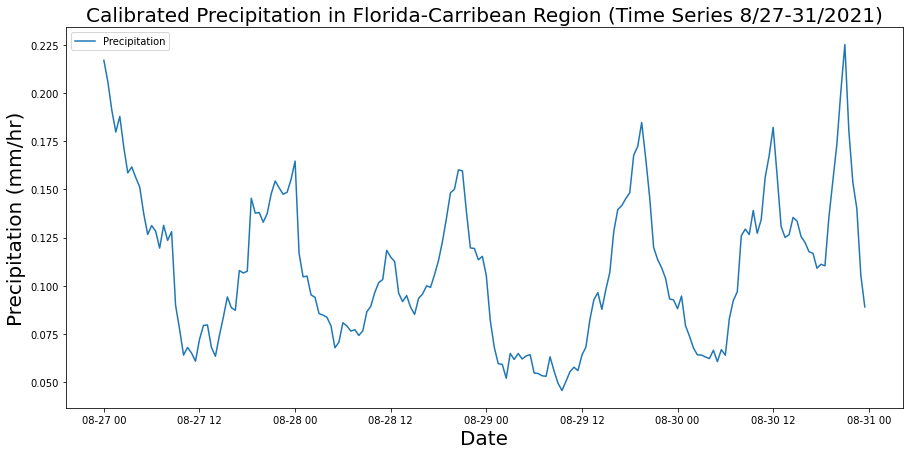

In [ ]:
# # Graphing ssm (year)

# # Create a figure with pyplot and set the dimensions to 15 x 7
# fig, ax = plt.subplots(figsize=(15,7))

# # Create the plot by setting our dataframe to the data argument
# sns.lineplot(data=ssm_df, ax=ax)

# # Set the labels and title
# ax.set_ylabel('SSM (mm)',fontsize=20)
# ax.set_xlabel('Date',fontsize=20)
# ax.set_title('Surface Soil Moisture in Florida-Carribean Region (Time Series 2017)',fontsize=20);

# Graphing precipCal

# Create a figure with pyplot and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15,7))

# Create the plot by setting our dataframe to the data argument
sns.lineplot(data=precip_df, ax=ax)

# Set the labels and title
ax.set_ylabel('Precipitation (mm/hr)',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Calibrated Precipitation in Florida-Carribean Region (Time Series 8/27-31/2021)',fontsize=20);

#Time Series Animation
Use geemap video features to create downloadble gif animation from imageCollection.

##References:
- [Create Landsat Timelapse](https://github.com/giswqs/geemap/blob/master/examples/notebooks/18_create_landsat_timelapse.ipynb)

- [Exploring Seasonal Variations in Vegetation Cover around Indian Subcontinent](https://towardsdatascience.com/exploring-seasonal-variations-in-vegetation-cover-around-indian-subcontinent-dd9885edbf4)

In [ ]:
import os

In [ ]:
ssm = ee.ImageCollection("NASA_USDA/HSL/SMAP10KM_soil_moisture").filterDate('2017-01-01','2018-01-01').select('ssm')
aoi = ee.Geometry.Polygon([[-88.20, 30.99], [-59.68, 20.06] , [-62.45, 8.09] , [-86.48, 14.29]]) #4 sided polygon with Florida, Puerto Rico, Carribean area within

In [ ]:
video_args = {
  'dimensions': 500,
  'region': aoi_map,
  'framesPerSecond': 10,
  'bands': 'ssm',
  'min': 0,
  'max': 25.0,
  'palette': ['0300ff', '418504', 'efff07', 'ff0303'], 
}

In [ ]:
work_dir = os.path.join(os.path.expanduser("~"), 'Downloads')
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
out_gif = os.path.join(work_dir, "ssm_ts.gif")

In [ ]:
#Get link (displays in another tab)
geemap.download_ee_video(ssm, video_args, out_gif)


Generating URL...
Please wait ...
The GIF image has been saved to: /root/Downloads/ssm_ts.gif


In [ ]:
#Display here
geemap.show_image(out_gif)

Output()

We can also add text:

In [ ]:
text = ['Jan-17','Jan-17','Jan-17','Jan-17','Jan-17','Jan-17','Jan-17','Jan-17','Jan-17','Jan-17', \
        'Feb-17','Feb-17','Feb-17','Feb-17','Feb-17','Feb-17','Feb-17','Feb-17','Feb-17','Feb-17',\
        'Mar-17','Mar-17','Mar-17','Mar-17','Mar-17','Mar-17','Mar-17','Mar-17','Mar-17','Mar-17',\
        'Apr-17','Apr-17','Apr-17','Apr-17','Apr-17','Apr-17','Apr-17','Apr-17','Apr-17','Apr-17',\
        'May-17','May-17','May-17','May-17','May-17','May-17','May-17','May-17','May-17','May-17',\
        'Jun-17','Jun-17','Jun-17','Jun-17','Jun-17','Jun-17','Jun-17','Jun-17','Jun-17','Jun-17',\
        'Jul-17','Jul-17','Jul-17','Jul-17','Jul-17','Jul-17','Jul-17','Jul-17','Jul-17','Jul-17',\
        'Aug-17','Aug-17','Aug-17','Aug-17','Aug-17','Aug-17','Aug-17','Aug-17','Aug-17', 'Aug-17',\
        'Sep-17','Sep-17','Sep-17','Sep-17','Sep-17','Sep-17','Sep-17','Sep-17','Sep-17','Sep-17',\
        'Oct-17','Oct-17','Oct-17','Oct-17','Oct-17','Oct-17','Oct-17','Oct-17','Oct-17','Oct-17',\
        'Nov-17','Nov-17','Nov-17','Nov-17','Nov-17','Nov-17','Nov-17','Nov-17','Nov-17','Nov-17',\
        'Dec-17','Dec-17','Dec-17','Dec-17','Dec-17','Dec-17','Dec-17','Dec-17','Dec-17','Dec-17','Jan-18'] #custom text sequence (SSM measured every 3 days) *note: needs to match number of images 
texted_gif = os.path.join(work_dir, "ssm_ts.gif")
geemap.add_text_to_gif(out_gif, texted_gif, xy=('70%', '5%'), text_sequence = text, font_size=30, font_color='#ffffff', add_progress_bar=False)


In [ ]:
label = 'SSM'
geemap.add_text_to_gif(texted_gif, texted_gif, xy=('8%', '88%'), text_sequence=label, font_size=30, font_color='#ffffff', progress_bar_color='blue')

In [ ]:
geemap.show_image(texted_gif)

Output()